# Imports

In [3]:
import pandas as pd
import glob
import os
import numpy as np
from featureranker.utils import *
from featureranker.plots import *
from featureranker.rankers import *
from tqdm.auto import tqdm
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

# Functions

In [89]:
# functions
def get_names(df, start, stop):
    player_list = []
    drop_list = df.iloc[:, start:stop:3].columns.tolist()
    name_df = df.drop(drop_list, axis=1, inplace=False)
    name_df = name_df.iloc[:, start:stop-len(drop_list)]
    for i in range(len(name_df)):
        players = name_df.iloc[i].tolist()
        players_sorted = [players[j] for j in range(0, len(players), 2)]
        players_sorted.sort(key=lambda x: players[players.index(x) + 1])
        player_list.append(players_sorted)
    return player_list


def list_stacker(pitchers, players):
    for i in range(len(pitchers)):
        players[i].insert(0, pitchers[i])
    return players


def get_game_data(paths):
    all_data = []
    for i in range(len(paths)):
        df = pd.read_csv(paths[i], header=None)
        visiting_players = get_names(df, 105, 132)
        home_players = get_names(df, 132, 159)
        home_pitchers = df.iloc[:, 104].tolist()
        visiting_pitchers = df.iloc[:, 102].tolist()
        visiting_players = list_stacker(visiting_pitchers, visiting_players)
        home_players = list_stacker(home_pitchers, home_players)
        visiting_scores = df.iloc[:, 9].tolist()
        home_scores = df.iloc[:, 10].tolist()
        all_data.extend(list(zip(visiting_players, home_players, visiting_scores, home_scores)))
    return all_data


def get_player_data(paths):
    le = LabelEncoder()
    player_dfs = []
    for path in paths:
        df = pd.read_csv(path)
        df['Team'] = le.fit_transform(df['Team'])
        if 'Pos' in df.columns:
            df['Pos'] = le.fit_transform(df['Pos'])
        if 'Batters' not in path:
            df['ExtraCol1'] = 0
            df['ExtraCol2'] = 0
            df['ExtraCol3'] = 0
        df.columns = ['Player'] + list(range(len(df.columns) - 1))
        df['Player'] = df['Player'].str.lower()
        player_dfs.append(df)
    combined_player = pd.concat(player_dfs)
    combined_player = combined_player.groupby('Player', as_index=False).mean()
    final_player = combined_player.set_index('Player').T.to_dict('list')
    return final_player


def get_example(game, player_data):
    visiting_players = game[0]
    home_players = game[1]
    visiting_vector = [player_data[player.lower()] for player in visiting_players]
    home_vector = [player_data[player.lower()] for player in home_players]
    stacked_vector = [item for sublist in visiting_vector + home_vector for item in sublist]
    if game[2] > game[3]:
        label = 0
    else:
        label = 1
    return stacked_vector, label


def generate_vectors_and_labels(game_data, player_data):
    vectors, labels = [], []
    for game in tqdm(game_data):
        try:
            vector, label = get_example(game, player_data)
            if np.isnan(vector).any() or np.isnan(label):
                continue
            vectors.append(vector)
            labels.append(label)
        except:
            continue
    return pd.DataFrame(np.array(vectors)), pd.DataFrame(np.array(labels))


def get_vector(game, player_data):
    visiting_players = game[0]
    home_players = game[1]
    visiting_vector = [player_data[player.lower()] for player in visiting_players]
    home_vector = [player_data[player.lower()] for player in home_players]
    vector = [item for sublist in visiting_vector + home_vector for item in sublist]
    return np.array(vector)


# NN
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x


def train(model,
          train_loader,
          test_loader,
          optimizer,
          criterion,
          best_model_path='./best_model.pth',
          patience=10,
          epochs=100):
    
    best_loss = float('inf')
    for epoch in range(epochs):  # number of epochs
        model.train()
        train_losses = []
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        print(f'Training Loss: {avg_train_loss}')

        model.eval()
        valid_losses = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())
                valid_losses.append(loss.item())

        avg_valid_loss = np.mean(valid_losses)
        print(f'Validation Loss: {avg_valid_loss}')

        # Update the best model if validation loss improves
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    # Load the best model
    model.load_state_dict(torch.load(best_model_path))

    # Evaluate the best model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return model, all_preds, all_labels


# def generate_bets(model,
#                   games,
#                   player_dict,
#                   bet_fixed=True,
#                   base_bet=10):
#     model.eval()
#     preds, bets = [], []
#     for i, game in tqdm(enumerate(games), total=len(games), desc='Predicting games'):
#         try:
#             vector = get_vector(game, player_dict)
#             if np.isnan(vector).any():
#                 print(f'NAN in game {i}')
#                 continue
#         except:
#             print(f'Some players were not found game {i}')
#             continue
#         logits = model(torch.tensor(vector, dtype=torch.float))
#         pred = logits.argmax().item()
#         preds.append(pred)
#         if bet_fixed:
#             bets.append(base_bet)
#         #else:
#             #bets.append(base_bet * (1/probs[pred].item()))
#     return preds, bets


# def simulate_betting(preds, bets, odds, results, wallet_balance=1000.0):
#     wallet_balance_history = []
#     for i, bet in tqdm(enumerate(bets), total=len(bets), desc='Updating wallet'):
#         if preds[i] == 1: # home win
#             if results[i] == 1: # correct bet
#                 home_open = odds[i][0]
#                 if home_open >= 0:
#                     wallet_balance += bet * (home_open / 100.0)
#                 else:
#                     wallet_balance += bet * (100.0 / abs(home_open))
#             else:
#                 wallet_balance -= bet
#         else: # visit win
#             if results[i] == 0: # correct bet
#                 visit_open = odds[i][1]
#                 if visit_open >= 0:
#                     wallet_balance += (visit_open / 100.0)
#                 else:
#                     wallet_balance += bet * (100.0 / abs(visit_open))
#             else:
#                 wallet_balance -= bet
#         wallet_balance_history.append(wallet_balance)
#     return wallet_balance, wallet_balance_history


# Load data

In [85]:
player_path = './player_data/'
paths = [path.replace('\\', '/') for path in glob(player_path + '*.csv')]
for path in paths:
    df = pd.read_csv(path)
    view_data(df)

There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset
There are no NaN values in the dataset


In [86]:
# load data
test_year = '2021'
game_path = './game_data/'
player_path = './player_data/'

game_csvs_train = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if test_year not in path]
game_csvs_test = [path.replace('\\', '/') for path in glob(game_path + '*.txt') if test_year in path]

player_csvs_train = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if test_year not in path]
player_csvs_test = [path.replace('\\', '/') for path in glob(player_path + '*.csv') if test_year in path]

train_game_data = [game for game in get_game_data(game_csvs_train) if game[2] != game[3]]
test_game_data = [game for game in get_game_data(game_csvs_test) if game[2] != game[3]]

train_player_data = get_player_data(player_csvs_train)
test_player_data = get_player_data(player_csvs_test)

X_train, y_train = generate_vectors_and_labels(train_game_data, train_player_data)
X_test, y_test = generate_vectors_and_labels(test_game_data, test_player_data)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

  0%|          | 0/27624 [00:00<?, ?it/s]

  0%|          | 0/2429 [00:00<?, ?it/s]

# Train NN

In [87]:
model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.2)

train_dataset = vector_dataset(X_train, y_train)
test_dataset = vector_dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

patience = 5
best_model_path = 'best_model.pth'  # File path for saving the best model

model, all_preds, all_labels = train(model=model,
                                     train_loader=train_loader,
                                     test_loader=test_loader,
                                     optimizer=optimizer,
                                     criterion=criterion,
                                     patience=patience)
# Calculate confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Epoch 1:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.6837672035945089
Validation Loss: 0.6717091287885394


Epoch 2:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.6702689951971957
Validation Loss: 0.680106194955962


Epoch 3:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.6617998104346426
Validation Loss: 0.6700153946876526


Epoch 4:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.6509686755506616
Validation Loss: 0.6781029637370791


Epoch 5:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.6391061469128257
Validation Loss: 0.7051554577691215


Epoch 6:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.619513612044485
Validation Loss: 0.6773585315261569


Epoch 7:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.5916179059367431
Validation Loss: 0.6918556264468602


Epoch 8:   0%|          | 0/190 [00:00<?, ?it/s]

Training Loss: 0.5594144504321249
Validation Loss: 0.6965077029807227
Early stopping triggered
Confusion Matrix:
[[451 386]
 [349 604]]
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.54      0.55       837
           1       0.61      0.63      0.62       953

    accuracy                           0.59      1790
   macro avg       0.59      0.59      0.59      1790
weighted avg       0.59      0.59      0.59      1790



# Train SVM

In [9]:
# SVM
# Define hyperparameters for search
param_grid = param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],'kernel': ['rbf', 'poly', 'sigmoid']}


# Grid search for hyperparameters
clf = GridSearchCV(svm.SVC(), param_grid, refit=True, cv=3, verbose=3)
clf.fit(X_train, y_train)

# Predict using the best model
y_pred = clf.predict(X_test)

class_report = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_)
disp.plot()

print("Classification Report:")
print(class_report)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.536 total time=  32.8s
[CV 2/3] END ........C=0.1, gamma=1, kernel=rbf;, score=0.536 total time=  32.1s


# Feature ranking

Fitting 3 folds for each of 10 candidates, totalling 30 fits


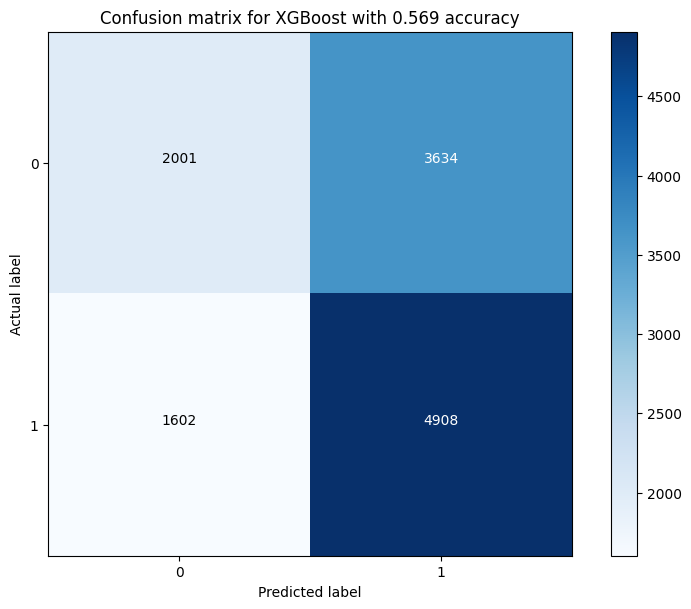

Fitting 3 folds for each of 10 candidates, totalling 30 fits


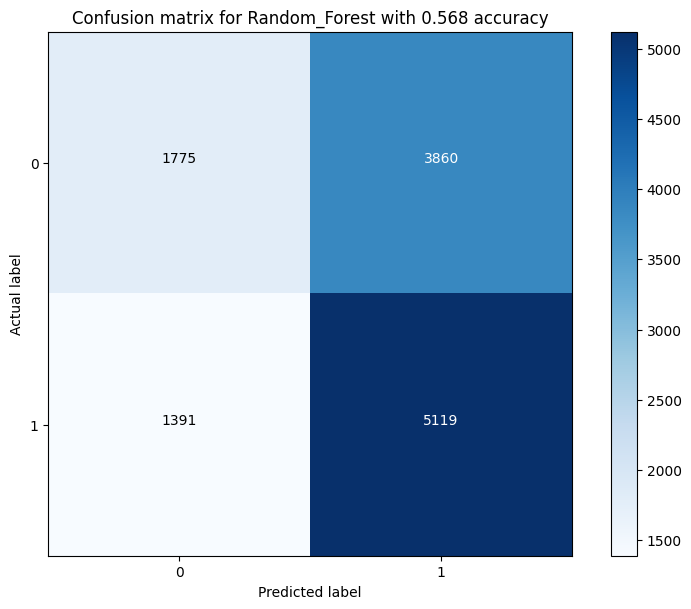

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [6]:
# forests and feature ranking
hypers = classification_hyper_param_search(X_train, y_train, 3, 10)
xb_hypers = hypers[0]['best_params']
rf_hypers = hypers[1]['best_params']
ranking = classification_ranking(X_train, y_train, rf_hypers, xb_hypers)
scoring = voting(ranking)
#plot_ranking(scoring, title='Classification example')

# Betting

In [65]:
xlsx_path = './betting_odds/'
txt_path = './alldata/gamelogs/'
glfields_path = './alldata/gamelogs/glfields.txt'
paths = [path for path in glob(xlsx_path + '*.xlsx')]
paths_txt = [f'{txt_path}gl20{year}.txt' for year in range(10, 24)]
schedule_paths = [f'./alldata/schedules/{year}schedule.csv' for year in range(2010, 2024)]
xlsx_dataframes = []
for i, path in enumerate(paths):
    temp_df = pd.read_excel(path, skiprows=0 if i > 0 else 0)
    temp_df.columns = temp_df.columns.str.replace('[^a-zA-Z0-9]', '')
    year = path[-9:-5]  # extract year from file name
    if 'Date' in temp_df.columns:
        temp_df['Date'] = year + temp_df['Date'].astype(str).str.zfill(4)  # format date as yyyymmdd
    xlsx_dataframes.append(temp_df)

try:
    xlsx_dataframes = pd.concat(xlsx_dataframes, ignore_index=True)
except pd.errors.InvalidIndexError:
    print("Error: Reindexing only valid with uniquely valued Index objects")

with open(glfields_path, 'r') as file:
    glfields_data = file.read()

xlsx_dataframes = xlsx_dataframes[['Date', 'VH', 'Team', 'Open']]
home_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'H'].copy()
visiting_teams_df = xlsx_dataframes[xlsx_dataframes['VH'] == 'V'].copy()

home_teams_df.columns = ['date', 'VH', 'home_team', 'home_open']
visiting_teams_df.columns = ['date', 'VH', 'visiting_team', 'visiting_open']
home_teams_df=home_teams_df[['date','home_team','home_open']]
visiting_teams_df=visiting_teams_df[['date','visiting_team','visiting_open']]
xlsx_dataframes=pd.merge(home_teams_df,visiting_teams_df,on='date')
xlsx_dataframes = xlsx_dataframes[['date', 'home_team', 'visiting_team','home_open','visiting_open']]

headers = [
    "date",
    "number_of_game",
    "day_of_week",
    "visiting_team",
    "visiting_team_league",
    "visiting_team_game_number",
    "home_team",
    "home_team_league",
    "home_team_game_number",
    "visiting_team_score",
    "home_team_score",
    "length_of_game_in_outs",
    "day_night_indicator",
    "completion_information",
    "forfeit_information",
    "protest_information",
    "park_id",
    "attendance",
    "time_of_game_in_minutes",
    "visiting_team_line_scores",
    "home_team_line_scores",
    "visiting_team_at_bats",
    "visiting_team_hits",
    "visiting_team_doubles",
    "visiting_team_triples",
    "visiting_team_homeruns",
    "visiting_team_RBI",
    "visiting_team_sacrifice_hits",
    "visiting_team_sacrifice_flies",
    "visiting_team_hit_by_pitch",
    "visiting_team_walks",
    "visiting_team_intentional_walks",
    "visiting_team_strikeouts",
    "visiting_team_stolen_bases",
    "visiting_team_caught_stealing",
    "visiting_team_grounded_into_double_plays",
    "visiting_team_awarded_first_on_catchers_interference",
    "visiting_team_left_on_base",
    "visiting_team_pitchers_used",
    "visiting_team_individual_earned_runs",
    "visiting_team_team_earned_runs",
    "visiting_team_wild_pitches",
    "visiting_team_balks",
    "visiting_team_putouts",
    "visiting_team_assists",
    "visiting_team_errors",
    "visiting_team_passed_balls",
    "visiting_team_double_plays",
    "visiting_team_triple_plays",
    "home_team_at_bats",
    "home_team_hits",
    "home_team_doubles",
    "home_team_triples",
    "home_team_homeruns",
    "home_team_RBI",
    "home_team_sacrifice_hits",
    "home_team_sacrifice_flies",
    "home_team_hit_by_pitch",
    "home_team_walks",
    "home_team_intentional_walks",
    "home_team_strikeouts",
    "home_team_stolen_bases",
    "home_team_caught_stealing",
    "home_team_grounded_into_double_plays",
    "home_team_awarded_first_on_catchers_interference",
    "home_team_left_on_base",
    "home_team_pitchers_used",
    "home_team_individual_earned_runs",
    "home_team_team_earned_runs",
    "home_team_wild_pitches",
    "home_team_balks",
    "home_team_putouts",
    "home_team_assists",
    "home_team_errors",
    "home_team_passed_balls",
    "home_team_double_plays",
    "home_team_triple_plays",
    "home_plate_umpire_id",
    "home_plate_umpire_name",
    "first_base_umpire_id",
    "first_base_umpire_name",
    "second_base_umpire_id",
    "second_base_umpire_name",
    "third_base_umpire_id",
    "third_base_umpire_name",
    "left_field_umpire_id",
    "left_field_umpire_name",
    "right_field_umpire_id",
    "right_field_umpire_name",
    "visiting_team_manager_id",
    "visiting_team_manager_name",
    "home_team_manager_id",
    "home_team_manager_name",
    "winning_pitcher_id",
    "winning_pitcher_name",
    "losing_pitcher_id",
    "losing_pitcher_name",
    "saving_pitcher_id",
    "saving_pitcher_name",
    "game_winning_rbi_batter_id",
    "game_winning_rbi_batter_name",
    "visiting_starting_pitcher_id",
    "visiting_starting_pitcher_name",
    "home_starting_pitcher_id",
    "home_starting_pitcher_name",
]
for i in range(1, 10):
    headers.extend([
        f"visiting_starting_player_{i}_id",
        f"visiting_starting_player_{i}_name",
        f"visiting_starting_player_{i}_defensive_position"
    ])

for i in range(1, 10):
    headers.extend([
        f"home_starting_player_{i}_id",
        f"home_starting_player_{i}_name",
        f"home_starting_player_{i}_defensive_position"
    ])

headers.extend(["additional_information", "acquisition_information"])

txt_dataframes = []
for path_txt in paths_txt:
    df = pd.read_csv(path_txt, delimiter = ",", quotechar='"', quoting=1, header = None)
    df.columns = headers
    txt_dataframes.append(df)
    # view_data(df)
# txt_dataframes = txt_dataframes.replace({',': '', '\"': ''}, regex=True)
# If you want to view the file in Excel, uncomment the following line
# os.startfile(xlsx_files[0])
# Concatenate all dataframes in txt_dataframes into a single dataframe
txt_dataframes_concat = pd.concat(txt_dataframes)
len(txt_dataframes_concat)

# Determine the winning team for each game and add it as a new column 'winner'
txt_dataframes_concat['winner'] = txt_dataframes_concat.apply(lambda row: 1 if row["home_team_score"] > row["visiting_team_score"] else 2 if row["home_team_score"] == row["visiting_team_score"] else 0, axis=1)

# Drop all columns except for the visiting and home pitchers, starting players, home_team, visiting_team, date, coach, and winner
# txt_dataframes_concat = txt_dataframes_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
#                                               'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
#                                               'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
#                                               'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
#                                               'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
#                                               'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
#                                               'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
#                                               'home_team_score','visiting_team_score','winner']]
txt_dataframes_concat = txt_dataframes_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
                                              'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
                                              'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
                                              'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
                                              'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
                                              'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
                                              'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
                                              'winner']]

xlsx_dataframes['date'] = xlsx_dataframes['date'].astype(int)
txt_dataframes_concat['date'] = txt_dataframes_concat['date']
# Now perform the merge operation
merged_dataframes = pd.merge(xlsx_dataframes, txt_dataframes_concat, on=['date', 'home_team', 'visiting_team'])
merged_dataframes_full = pd.merge(txt_dataframes_concat,xlsx_dataframes, on=['date', 'home_team', 'visiting_team'],how="left")


player_list_concat = pd.concat(txt_dataframes)
player_list_concat = player_list_concat[['date', 'home_team', 'visiting_team', 'home_starting_pitcher_name', 'visiting_starting_pitcher_name', 
                                              'home_starting_player_1_name', 'home_starting_player_2_name', 'home_starting_player_3_name', 
                                              'home_starting_player_4_name', 'home_starting_player_5_name', 'home_starting_player_6_name', 
                                              'home_starting_player_7_name', 'home_starting_player_8_name', 'home_starting_player_9_name', 
                                              'visiting_starting_player_1_name', 'visiting_starting_player_2_name', 'visiting_starting_player_3_name', 
                                              'visiting_starting_player_4_name', 'visiting_starting_player_5_name', 'visiting_starting_player_6_name', 
                                              'visiting_starting_player_7_name', 'visiting_starting_player_8_name', 'visiting_starting_player_9_name',
                                              'home_team_score','visiting_team_score',
                                              'home_starting_player_1_defensive_position', 'home_starting_player_2_defensive_position', 
                                              'home_starting_player_3_defensive_position', 'home_starting_player_4_defensive_position', 
                                              'home_starting_player_5_defensive_position', 'home_starting_player_6_defensive_position', 
                                              'home_starting_player_7_defensive_position', 'home_starting_player_8_defensive_position', 
                                              'home_starting_player_9_defensive_position', 'visiting_starting_player_1_defensive_position', 
                                              'visiting_starting_player_2_defensive_position', 'visiting_starting_player_3_defensive_position', 
                                              'visiting_starting_player_4_defensive_position', 'visiting_starting_player_5_defensive_position', 
                                              'visiting_starting_player_6_defensive_position', 'visiting_starting_player_7_defensive_position', 
                                              'visiting_starting_player_8_defensive_position', 'visiting_starting_player_9_defensive_position']]

player_list_concat['lineup'] = player_list_concat.apply(lambda row: [
    (
        (row['visiting_starting_pitcher_name'],) +
        tuple(row[f'visiting_starting_player_{i}_name'] for i in sorted(range(1, 10), key=lambda i: row[f'visiting_starting_player_{i}_defensive_position']))
    ),
    (
        (row['home_starting_pitcher_name'],) +
        tuple(row[f'home_starting_player_{i}_name'] for i in sorted(range(1, 10), key=lambda i: row[f'home_starting_player_{i}_defensive_position']))
    ),
    # row['visiting_team_score'],
    # row['home_team_score']
], axis=1).tolist()

merged_player_dataframe = pd.merge(xlsx_dataframes, player_list_concat, on=['date', 'home_team', 'visiting_team'])
merged_dataframes['odds'] = list(zip(merged_dataframes['home_open'], merged_dataframes['visiting_open']))

# Run bets

In [81]:
games = merged_player_dataframe['lineup'].tolist() # [(home players), (visiting players)]
odds = merged_dataframes['odds'].tolist() # (home, visint)
results = merged_dataframes['winner'].tolist() # 1 home, 0 visiting
len(games), len(odds), len(results)

(11205, 11205, 11205)

In [48]:
missing_players = set(test_player_data.keys()) - set([player.lower() for game in games for player in game[0] + game[1]])
len(missing_players)

641

Predicting games:   0%|          | 0/11205 [00:00<?, ?it/s]

Some players were not found game 0
Some players were not found game 1
Some players were not found game 2
Some players were not found game 3
Some players were not found game 4
Some players were not found game 5
Some players were not found game 6
Some players were not found game 7
Some players were not found game 8
Some players were not found game 9
Some players were not found game 10
Some players were not found game 11
Some players were not found game 12
Some players were not found game 13
Some players were not found game 14
Some players were not found game 15
Some players were not found game 16
Some players were not found game 17
Some players were not found game 18
Some players were not found game 19
Some players were not found game 20
Some players were not found game 21
Some players were not found game 22
Some players were not found game 23
Some players were not found game 24
Some players were not found game 25
Some players were not found game 26
Some players were not found game 27
So

Updating wallet:   0%|          | 0/4988 [00:00<?, ?it/s]

-15505.552235203
[1005.0, 1006.05, 996.05, 1004.05, 1011.1928571428571, 1001.1928571428571, 991.1928571428571, 997.5622838944494, 998.9422838944494, 988.9422838944494, 978.9422838944494, 980.0422838944494, 970.0422838944494, 976.6212312628704, 966.6212312628704, 956.6212312628704, 957.7712312628704, 947.7712312628704, 955.1786386702778, 945.1786386702778, 935.1786386702778, 942.5860460776852, 943.9060460776852, 949.4616016332408, 939.4616016332408, 929.4616016332408, 930.5616016332408, 920.5616016332408, 910.5616016332408, 919.4901730618122, 931.7901730618122, 941.2241353259632, 931.2241353259632, 921.2241353259632, 928.9164430182709, 938.2622374107942, 928.2622374107942, 918.2622374107942, 908.2622374107942, 898.2622374107942, 888.2622374107942, 897.3531465017033, 887.3531465017033, 877.3531465017033, 867.3531465017033, 857.3531465017033, 847.3531465017033, 837.3531465017033, 827.3531465017033, 817.3531465017033, 807.3531465017033, 797.3531465017033, 805.7565078462412, 795.75650784624

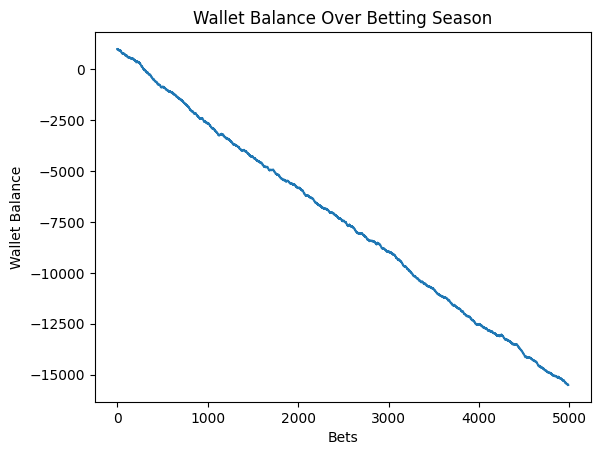

In [90]:
preds, bets = generate_bets(model=model,
                     games=games,
                     player_dict=train_player_data,
                     bet_fixed=True)
print(len(preds))
wallet_balance, wallet_balance_history = simulate_betting(preds=preds,
                                                          bets=bets,
                                                          odds=odds,
                                                          results=results)
print(wallet_balance)
print(wallet_balance_history)
plt.plot(wallet_balance_history)
plt.title('Wallet Balance Over Betting Season')
plt.xlabel('Bets')
plt.ylabel('Wallet Balance')
plt.show()

# Random

In [ ]:
"""
EXTRA
def get_player_data(paths):
    player_dfs = [pd.read_csv(path) for path in paths]
    player_dfs = [df.assign(Name=df['last_name, first_name'].apply(lambda x: ' '.join(x.split(', ')[::-1]).lower())).drop(columns=['player_id', 'last_name, first_name']) for df in player_dfs]
    combined_player = pd.concat(player_dfs).groupby('Name', as_index=False).mean()
    final_player = combined_player.set_index('Name').T.to_dict('list')
    return final_player

df.iloc[:, 102] # visiting pitchers
df.iloc[:, 104] # home pitchers
df.iloc[:, 105:132] # visiting players
df.iloc[:, 132:159] # home players
df.iloc[:, 9] # visiting score
df.iloc[:, 10] # home score
df.iloc[:, 3] # visiting team
df.iloc[:, 6] # home team
visiting_teams = df.iloc[:, 3].tolist()
home_teams = df.iloc[:, 6].tolist()
"""

"""
# instantiate the random undersampler
rus = RandomUnderSampler(random_state=42)

# instantiate SMOTE
smote = SMOTE(random_state=42)

# resample X_train and y_train using undersampling
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# resample X_train and y_train using SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# print the new class distribution after undersampling
print('Resampled dataset shape after undersampling %s' % len(X_train_resampled))

# print the new class distribution after SMOTE
print('Resampled dataset shape after SMOTE %s' % len(X_train_smote))
"""